In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.regularizers import l1
from keras.applications.resnet50 import preprocess_input

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

TensoFlow Version:  2.3.1


In [2]:
nb_classes = 73

datagen = ImageDataGenerator()
data = datagen.flow_from_directory('../input/dataset-2',
                                    target_size=(100, 100),
                                    batch_size=21663,
                                    class_mode='categorical',
                                    shuffle=True )

Found 21663 images belonging to 73 classes.


In [5]:
X , y = data.next()


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [4]:
import PIL
PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
# Labels are one hot encoded
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(21663, 100, 100, 3)
Labels shape :(21663, 73)


In [ ]:
import numpy as np
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow((X[r].astype('uint8')))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))
    

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [8]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (17330, 100, 100, 3)
Test Shape : (4333, 100, 100, 3)


In [9]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (100,100,3))

In [10]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128,activation='relu')(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)


In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.23, patience=5, min_lr=0.001)
checkpoint = ModelCheckpoint('best_model.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
n_epochs = 40
history = model.fit(X_train, y_train,validation_split=0.3,batch_size = 30, epochs = n_epochs, verbose = 2, callbacks =[reduce_lr,checkpoint] )

Epoch 1/40
405/405 - 55s - loss: 4.3214 - accuracy: 0.0184 - val_loss: 4.2247 - val_accuracy: 0.0339
Epoch 2/40
405/405 - 28s - loss: 3.9078 - accuracy: 0.0525 - val_loss: 5.4254 - val_accuracy: 0.0575
Epoch 3/40
405/405 - 27s - loss: 3.4782 - accuracy: 0.1011 - val_loss: 4.6198 - val_accuracy: 0.0960
Epoch 4/40
405/405 - 55s - loss: 3.1625 - accuracy: 0.1508 - val_loss: 3.3478 - val_accuracy: 0.1537
Epoch 5/40
405/405 - 54s - loss: 2.7978 - accuracy: 0.2234 - val_loss: 2.8277 - val_accuracy: 0.2252
Epoch 6/40
405/405 - 55s - loss: 2.4175 - accuracy: 0.2996 - val_loss: 2.2799 - val_accuracy: 0.3133
Epoch 7/40
405/405 - 27s - loss: 1.9836 - accuracy: 0.3803 - val_loss: 2.7132 - val_accuracy: 0.3043
Epoch 8/40
405/405 - 55s - loss: 1.5282 - accuracy: 0.4943 - val_loss: 1.3194 - val_accuracy: 0.5666
Epoch 9/40
405/405 - 55s - loss: 1.1930 - accuracy: 0.5977 - val_loss: 1.2135 - val_accuracy: 0.6013
Epoch 10/40
405/405 - 28s - loss: 0.9143 - accuracy: 0.6866 - val_loss: 1.4465 - val_accura

In [13]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

136/136 [==============================] - 3s 22ms/step - loss: 0.2262 - accuracy: 0.9557
Accuracy:  0.9556888937950134 
Loss    :  0.22624775767326355


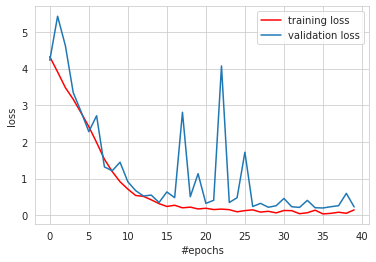

In [14]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('#epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

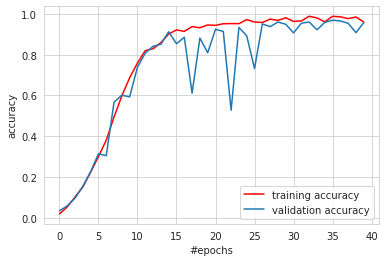

In [15]:


plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('#epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
import cv2,os
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import preprocess_input

data_path = "../input/dataset-2"
categories = os.listdir(data_path)
labels = []
labels=categories
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories,labels))
print(label_dict)
print(labels)
categories.sort()
print(categories)
print(classes)
print(labels)


In [17]:
classes = ['ALL MOTOR VEHICLES PROHIBITED', 'AXLE LOAD LIMIT', 'BULLOCK CART PROHIBITED', 'BULLOCK CART _ CART PROHIBITED', 'Barrier Ahead', 'COMPULSORY AHEAD ONLY', 'COMPULSORY CYCLE TRACK', 'COMPULSORY KEEP LEFT', 'COMPULSORY SOUND HORN', 'COMPULSORY TURN LEFT', 'COMPULSORY TURN RIGHT', 'CYCLE PROHIBITED', 'Cross Road', 'Dangerous Dip', 'Falling Rocks', 'Ferry', 'GIVE WAY', 'Gap In Median', 'Guarded Level Crossing(200 Metres)', 'Guarded Level Crossing(50-100 Metres)', 'HANDCARTS PROHIIBITED', 'HEIGHT LIMIT', 'HORN PROHIBITED', 'Hump or Rough Road', 'LEFT TURN PROHIBITED', 'LENGTH LIMIT', 'LOAD LIMIT', 'Major Road Ahead', 'NO ENTRY,STRAIGHT PROHIBITED', 'NO PARKING', 'NO STOPPING', 'ONE WAY', 'OVERTAKING PROHIBITED', 'PEDESTRIANS PROHIBITED', 'RESTRICTION ENDS', 'RIGHT TURN PROHIBITED', 'Roundabout', 'SPEED LIMIT', 'STOP', 'Side Road Left', 'Side Road Right', 'Staggered Intersection', 'T-Intersection', 'TONGAS PROHIBITED', 'TRUCK PROHIBITED', 'U TURN PROHIBITED', 'Unguarded Level Crossing (50-100 Metres)', 'Unguarded Level Crossing(200 Metres)', 'VEHICLE PROHIBITED IN BOTH DIRECTIONS', 'WIDTH LIMIT', 'Y-Intersection', 'cattle', 'compulsory ahead or turn left', 'compulsory ahead or turn right', 'compulsory turn left ahead', 'compulsory turn right ahead', 'cycle crossing', 'left hair pin bend', 'left hand curve', 'left reverse bend', 'loose gravel', 'men at work', 'narrow bridge', 'narrow road ahead', 'pedestrian crossing', 'right hair pin bend', 'right hand curve', 'right reverse bend', 'road wideness ahead', 'school ahead', 'slippery road', 'steep ascent', 'steep descent']

NameError: name 'classes' is not defined

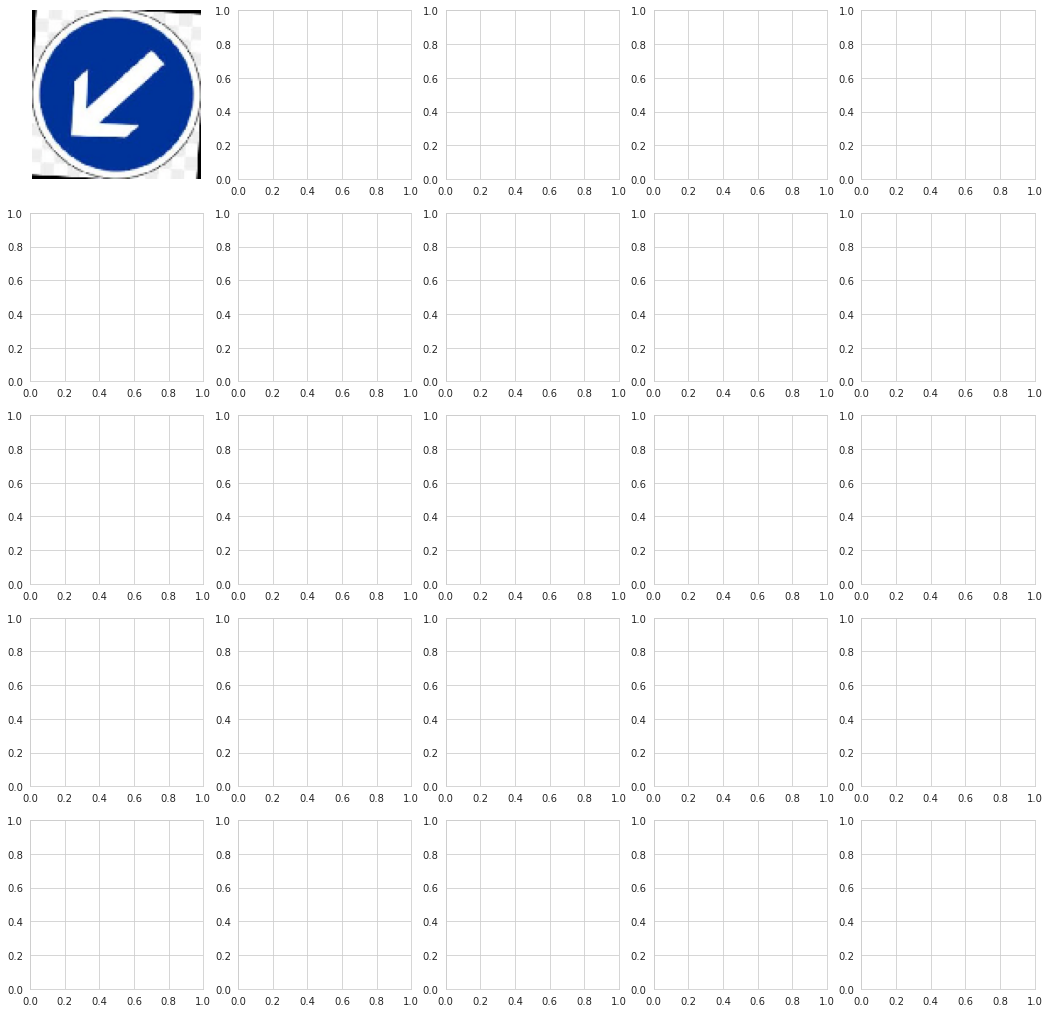

In [16]:
import numpy as np
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    true = classes[np.argmax(y_test[r])]
    pred = classes[np.argmax(model.predict((X_test[r].reshape(1, 100, 100, 3))))]
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]),np.argmax(model.predict(X_test[r].reshape(1, 100, 100, 3)))))

In [ ]:
# Saving the model
model.save('best_model.h5')

In [ ]:
pred = np.argmax(model.predict(X_test), axis = 1)

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1), pred, target_names = classes))

In [ ]:
cmat = confusion_matrix(np.argmax(y_test, axis=1), pred)
plt.figure(figsize=(16,16))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Paired', fmt="d", xticklabels=classes, yticklabels=classes);